In [1]:
import glob
import pickle
import numpy as np
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os.path

/opt/conda/envs/Base/lib/python3.9/site-packages/sktime/utils/validation/series.py:21: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)


In [2]:
fdf = get_problem_features(glob.glob('features/TSFresh.csv'))
pdf = get_problem_algorithm_performance('prediction_errors/mape.csv')
fdf = fdf.pipe(drop_nan_and_non_unique_columns)

get_problem_features took=0:00:26.408293 shape=(100000, 789)
get_problem_algorithm_performance took=0:00:02.142732 shape=(100000, 61)
drop_nan_and_non_unique_columns took=0:00:02.303005 shape=(100000, 323)


In [3]:
figures_directory = 'figures'

In [4]:
merged_file = 'shap_raw/merged_shapley.csv'

df = None

if os.path.exists(merged_file) == False:

    data_dict = {x:[] for x in fdf.columns}
    data_dict['name'] = []

    for file in tqdm(list(glob.glob('shap_raw/*.p'))):
        M = pickle.load(open(file, "rb" ))

        run = int(re_find('r_(.+?)_m_', file))
        meta_algo = re_find('m_(.+?)_f_', file)
        forecasting_model = re_find('-(.+?).p', file)
        #print(file, run, meta_algo, forecasting_model)

        if meta_algo == 'M4DummyMeanRegression':
            continue

        X_train, X_test, Y_train, Y_test = train_test_split(fdf, pdf, test_size=0.1, random_state=run)

        feature_correlation_threshold = 0.5

        if feature_correlation_threshold<1.0:
            shape_before = X_train.shape
            drop_columns = set(find_correlation(X_train, thresh=feature_correlation_threshold))
            X_train = X_train.drop(columns=drop_columns)
            X_test = X_test.drop(columns=drop_columns)
            shape_after = X_train.shape

        used_columns = list(X_train.columns)

        ts_names = X_test.head(512).index.to_list()
        data_dict['name'].extend(ts_names)
        for c, x in zip(used_columns, M.T):
            data_dict[c].extend(x)

        for c in fdf.columns:
            if c not in used_columns:
                data_dict[c].extend(M.shape[0] * [None])
                
    df = pd.DataFrame(data_dict)
    df.to_csv('shap_raw/merged_shapley.csv')

else:
    df = pd.read_csv('shap_raw/merged_shapley.csv')

100%|██████████| 3189/3189 [6:48:31<00:00,  7.69s/it]  


In [5]:
#df = pd.DataFrame(data_dict)
#df.to_csv('shap_raw/merged_shapley.csv')

In [6]:
df = df.dropna(axis=1, how='any')

In [7]:
for c in df.columns:
    if c.startswith('value__'):
        df[c] = df[c].abs()

In [8]:
df['name'] = df['name'].astype(str).str[0]

In [9]:
df2 = df.groupby(by=["name"]).mean().T.reset_index()
df2['index'] = df2['index'].map(get_feature_name_map())
df2 = df2.rename(columns={'D': 'Daily', 'H': 'Hourly', 'M': 'Monthly', 'Q': 'Quarterly', 'W': 'Weekly', 'Y': 'Yearly'})

In [10]:
df2

name,index,Daily,Hourly,Monthly,Quarterly,Weekly,Yearly
0,has_duplicate_max,0.000657,0.002155,0.000622,0.000363,0.000549,0.000473
1,mean_second_derivative_central,0.001301,0.002192,0.001735,0.002164,0.001147,0.006320
2,median,0.022774,0.083184,0.025288,0.025678,0.025154,0.027623
3,length,0.026143,0.014908,0.004584,0.004353,0.011974,0.007988
4,standard_deviation,0.023719,0.043854,0.023649,0.022692,0.028275,0.021303
...,...,...,...,...,...,...,...
58,ratio_beyond_r_sigma_r_2.5,0.001515,0.003171,0.001860,0.002119,0.002201,0.002389
59,ratio_beyond_r_sigma_r_3,0.000979,0.002417,0.001219,0.001147,0.001725,0.001246
60,ratio_beyond_r_sigma_r_6,0.000628,0.000856,0.000607,0.000442,0.000705,0.000494
61,lempel_ziv_complexity_bins_2,0.008526,0.007402,0.003631,0.002421,0.012699,0.004409


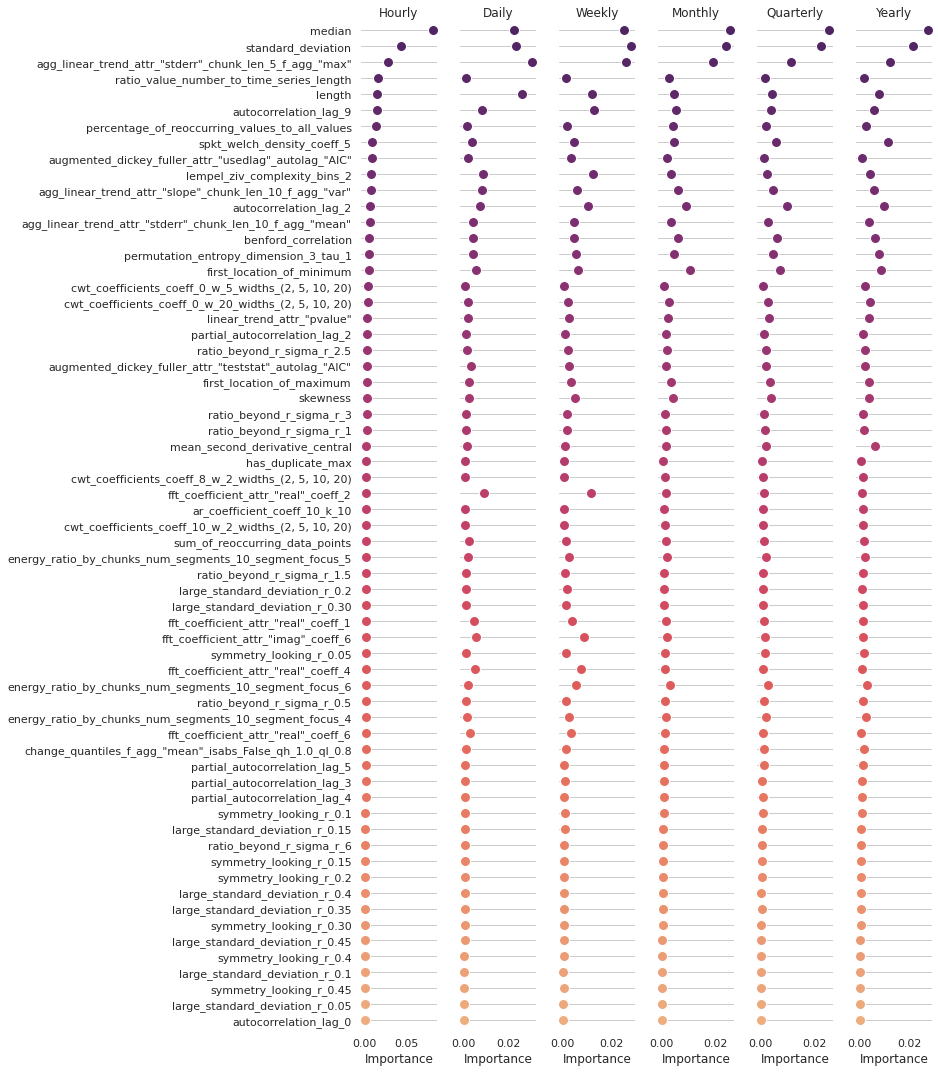

In [11]:
sns.set_theme(style="whitegrid")

# Use semantically meaningful titles for the columns
titles = ['Hourly', 'Daily', 'Weekly', 'Monthly', 'Quarterly', 'Yearly']

# Make the PairGrid
g = sns.PairGrid(df2.sort_values(by="Hourly", ascending=False),
                 x_vars=titles, y_vars=["index"],
                 height=15, aspect=.10)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h", jitter=False,
      palette="flare_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlabel="Importance", ylabel="")

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)
plt.savefig(f'{figures_directory}/feature_importance_per_frequency.pdf', bbox_inches='tight', pad_inches=0)